### Load in modules

In [1]:
import geopandas as gpd
import pandas as pd
import math
from shapely.geometry import Point
from pyproj import Proj, transform
import datetime as dt
import dendropy
import tqdm
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.patches as mpatches
from matplotlib import cm


### Load in shapefiles

In [2]:
uk_map = gpd.read_file('./data/shp/shapefile_out.shp')
uk_map = uk_map.to_crs('epsg:3395')

pc_map = gpd.read_file("./data/England_postcode_districts/England_postcode_districts.json")
pc_map.crs = "epsg:27700"
pc_map = pc_map.to_crs("epsg:3395")

inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3395')


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Process MCC tree

In [3]:
## function to convert date string to date object
def get_date_str(dec_date):
    date = dt.datetime(int(dec_date), 1, 1) + dt.timedelta(days = (dec_date % 1) * 365)

    return dt.datetime.strftime(date, '%Y-%m-%d')

## calculate great circle distance (km by default) given latitude and longitude
def get_displacement(pos_1, pos_2, km=True):
    R = 6371e3 ## Earth's radius in meters
    phi_1 = pos_1.y*math.pi/180
    phi_2 = pos_2.y*math.pi/180
    delta_phi = (pos_2.y - pos_1.y)*math.pi/180
    delta_lambda = (pos_2.x - pos_1.x)*math.pi/180
    
    a = math.sin(delta_phi/2)**2 + math.cos(phi_1)*math.cos(phi_2)*math.sin(delta_lambda/2)**2
    c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R*c
    
    return (d/1000 if km else d) ## return shortest distance in metres


*** (CAREFUL: this takes some time to run) ***

In [4]:
## read in MCC tree from continuous phylogeography
mcc_treefile = './data/BA11_DTA_1254_n2249_all_ltlas_final.cut_300m.b0.1.r60000.combined.mcc.tree'
tree = dendropy.Tree.get(path=mcc_treefile, schema='nexus')
## specify sample date of latest sequence
most_recent_dec_date = 2022.0821917808219

## name internal nodes
count = 0
for node in tree.preorder_node_iter():
    count += 1
    node.label = count
    
## extract information from tree
## what is this step doing:
## 1) project inferred coordinates onto flat space
## 2) find polygon containing the point
## 3) if no enclosing polygon can be found, assign point to closest polygon (from centroid)
edge_info = []
for edge in tqdm.tqdm(tree.edges()):
    if edge.tail_node:
        head_node = edge.tail_node ## tail_node in edge indicates older node (confusing defintion)
        head_dec_date = most_recent_dec_date - float(head_node.annotations['height'].value)
        head_date = get_date_str(head_dec_date)
        original_head_lat = head_node.annotations['coordinates1'].value
        original_head_long = head_node.annotations['coordinates2'].value
        
        tail_node = edge.head_node ## head_node in edge indicates younger node (confusing defintion)
        tail_dec_date = most_recent_dec_date - float(tail_node.annotations['height'].value)
        tail_date = get_date_str(tail_dec_date)
        original_tail_lat = tail_node.annotations['coordinates1'].value
        original_tail_long = tail_node.annotations['coordinates2'].value
        
        geo_dist = get_displacement(Point(float(original_head_long), float(original_head_lat)),
                                    Point(float(original_tail_long), float(original_tail_lat)))
        
        proj_head_long, proj_head_lat = transform(inProj, outProj, original_head_long, original_head_lat)
        proj_tail_long, proj_tail_lat = transform(inProj, outProj, original_tail_long, original_tail_lat)

        head_point = Point(float(proj_head_long), float(proj_head_lat))
        tail_point = Point(float(proj_tail_long), float(proj_tail_lat))
                
        head_ltla = None
        tail_ltla = None
        head_ltla_amb = False
        tail_ltla_amb = False
        head_ltla_amb_dists = {}
        tail_ltla_amb_dists = {}
        for ltla, polygon in zip(uk_map.geo_code.values, uk_map.geometry.values):
            head_ltla_amb_dist = polygon.distance(head_point)
            head_ltla_amb_dists[ltla] = head_ltla_amb_dist
            tail_ltla_amb_dist = polygon.distance(tail_point)
            tail_ltla_amb_dists[ltla] = tail_ltla_amb_dist
            if polygon.contains(head_point):
                head_ltla = ltla
            if polygon.contains(tail_point):
                tail_ltla = ltla
            if head_ltla and tail_ltla:
                break
        else:
            if not head_ltla:
                head_ltla_amb = True
                min_dist_ltla = sorted([(ltla, dist) for ltla, dist in head_ltla_amb_dists.items()],
                                       key=lambda x: x[1])[0]
                head_ltla = min_dist_ltla[0]
            if not tail_ltla:
                tail_ltla_amb = True
                min_dist_ltla = sorted([(ltla, dist) for ltla, dist in tail_ltla_amb_dists.items()],
                                       key=lambda x: x[1])[0]
                tail_ltla = min_dist_ltla[0]
        
        head_pc = None
        tail_pc = None
        for pc, polygon in zip(pc_map.PostDist.values, pc_map.geometry.values):
            if polygon.contains(head_point):
                head_pc = pc
            if polygon.contains(tail_point):
                tail_pc = pc
            if head_pc and tail_pc:
                break
                
        edge_info.append(
            {
                'head_node': head_node.label,
                'tail_node': tail_node.label,
                'length': edge.length,
                'geo_distance': geo_dist,
                'head_lat_3395': proj_head_lat,
                'head_long_3395': proj_head_long,
                'tail_lat_3395': proj_tail_lat,
                'tail_long_3395': proj_tail_long,
                'head_lat_4326': original_head_lat,
                'head_long_4326': original_head_long,
                'tail_lat_4326': original_tail_lat,
                'tail_long_4326': original_tail_long,
                'head_ltla': head_ltla,
                'head_ltla_amb': head_ltla_amb,
                'tail_ltla': tail_ltla,
                'tail_ltla_amb': tail_ltla_amb,
                'head_pc': head_pc,
                'tail_pc': tail_pc,
                'head_date': head_date,
                'head_dec_date': head_dec_date,
                'tail_date': tail_date,
                'tail_dec_date': tail_dec_date
            }
        )


  0%|          | 0/4497 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
100%|██████████| 4497/4497 [04:10<00:00, 17.92it/s]


In [9]:
## convert dictionary into dataframe
mcc_edge_df = pd.DataFrame(edge_info)
mcc_edge_df = mcc_edge_df.sort_values('head_date', ascending=False)
mcc_edge_df


,head_node,tail_node,length,geo_distance,head_lat_3395,head_long_3395,tail_lat_3395,tail_long_3395,head_lat_4326,head_long_4326,...,head_ltla,head_ltla_amb,tail_ltla,tail_ltla_amb,head_pc,tail_pc,head_date,head_dec_date,tail_date,tail_dec_date
4010,4010,4012,0.004451,0.731310,7.033016e+06,-309063.025487,7.034105e+06,-308497.433966,53.453714900701186,-2.7763603955093212,...,E08000013,False,E08000013,False,WA10,WA10,2022-01-29,2022.077740,2022-01-30,2022.082192
4009,4010,4011,0.004451,2.269390,7.033016e+06,-309063.025487,7.033130e+06,-312876.702613,53.453714900701186,-2.7763603955093212,...,E08000013,False,E08000011,False,WA10,WA10,2022-01-29,2022.077740,2022-01-30,2022.082192
4073,4071,4075,0.002718,0.743022,6.803341e+06,-243445.214343,6.804118e+06,-244376.206653,52.204177750130086,-2.186905568896651,...,E07000237,False,E07000237,False,WR4,WR4,2022-01-28,2022.073994,2022-01-29,2022.076712
4072,4072,4074,0.006672,0.418424,6.802983e+06,-243008.283411,6.802303e+06,-242962.208270,52.2022017378713,-2.182980551554543,...,E07000237,False,E07000237,False,WR4,WR4,2022-01-28,2022.075519,2022-01-30,2022.082192
4071,4072,4073,0.006672,0.472216,6.802983e+06,-243008.283411,6.803041e+06,-242239.086488,52.2022017378713,-2.182980551554543,...,E07000237,False,E07000237,False,WR4,WR4,2022-01-28,2022.075519,2022-01-30,2022.082192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2,3,0.002108,0.343361,6.683149e+06,-21212.087900,6.683094e+06,-20662.234967,51.53582061782925,-0.1905514276900717,...,E09000033,True,E09000033,False,NW6,NW8,2021-12-02,2021.918332,2021-12-02,2021.920440
649,3,651,0.017989,7.882235,6.683094e+06,-20662.234967,6.671776e+06,-15011.222228,51.53551188972602,-0.18561201474540057,...,E09000033,False,E09000022,False,NW8,SW8,2021-12-02,2021.920440,2021-12-09,2021.938430
734,2,736,0.002646,1.080207,6.683149e+06,-21212.087900,6.681890e+06,-20017.382241,51.53582061782925,-0.1905514276900717,...,E09000033,True,E09000033,False,NW6,NW8,2021-12-02,2021.918332,2021-12-03,2021.920977
3421,1,3423,0.010376,3.660518,6.685780e+06,-24545.012356,6.689520e+06,-29093.176841,51.5505575658127,-0.22049159748128516,...,E09000005,False,E09000005,False,NW2,NW9,2021-11-30,2021.912893,2021-12-03,2021.923269


### Plot viral movements on map

In [10]:
## import pre-processed mapping between date in decimal format and calendar date
dec_date_df = pd.read_csv('./data/final_tips/dec_date_map.tsv', sep='\t')
date_dec_map = dict(zip(dec_date_df.date.values, dec_date_df.dec_date.values))

## convert dates from decimal format to calendar dates
all_dates = [date_dec_map[x] for x in 
             (mcc_edge_df.head_date.unique().tolist() + mcc_edge_df.tail_date.unique().tolist())]

## generate colour spectrum from dates
norm = Normalize(vmin=min(all_dates), vmax=max(all_dates))
cmap = LinearSegmentedColormap.from_list("", ["#0C4C5F", "#de801b", "#fadc46"])
colour_dict = {}
for date in all_dates:
    colour_dict[date] = cmap(norm(date))
    

2it [00:00, 167.63it/s]


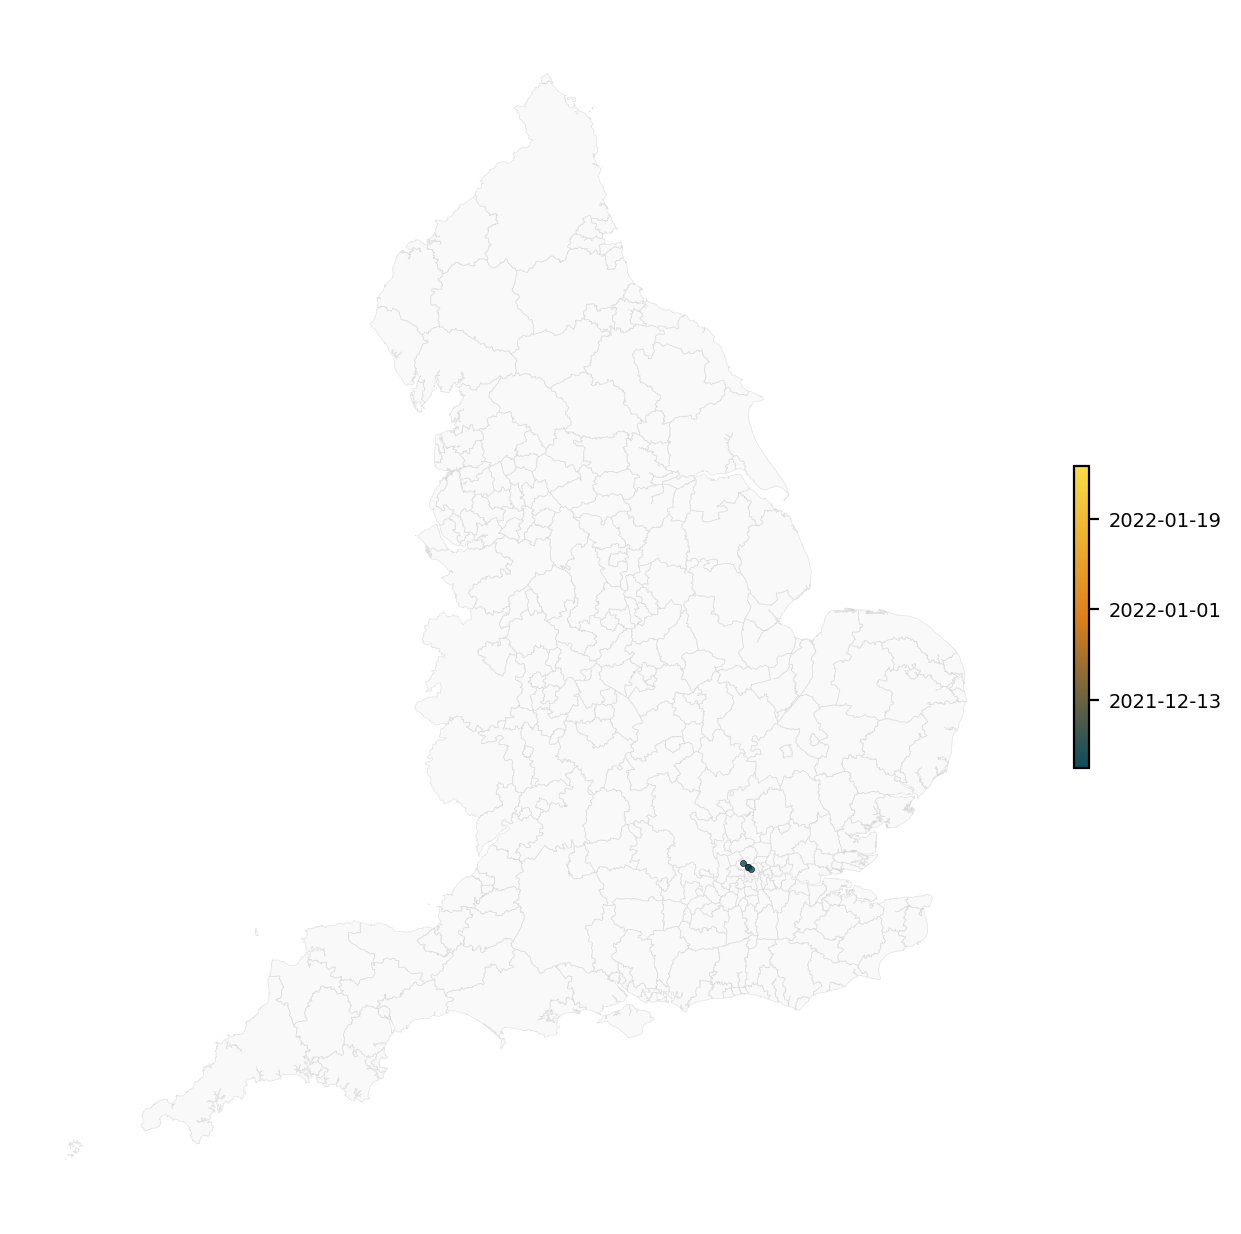

In [11]:
## specify date cut-off
cutoff_date = '2021-11-30'

## generate map
fig, ax = plt.subplots(1,1, figsize=(8, 8), dpi=200)
uk_map.plot(ax=ax, color='whitesmoke', ec='lightgrey', linewidth=0.25, alpha=0.6)
for index, row in tqdm.tqdm(mcc_edge_df[mcc_edge_df.head_date <= cutoff_date].iterrows()):
    head_pos = (row['head_long_3395'], row['head_lat_3395'])
    tail_pos = (row['tail_long_3395'], row['tail_lat_3395'])
    head_date = date_dec_map[row['head_date']]
    tail_date = date_dec_map[row['tail_date']]

    kw = dict(color="black", linewidth=0.1, alpha=0.75)

    liney = mpatches.FancyArrowPatch(head_pos, tail_pos, shrinkA=0, shrinkB=0,
                                     arrowstyle="-", connectionstyle="arc3, rad=.5", **kw)
    
    ax.add_patch(liney)

    ax.scatter(head_pos[0], head_pos[1], s=5, color=colour_dict[head_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=5)
    ax.scatter(tail_pos[0], tail_pos[1], s=5, color=colour_dict[tail_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=6)

bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.25)
new_ticks = []
for i in bar.get_ticks():
    new_ticks.append(get_date_str(i))
bar.set_ticks(bar.get_ticks())
bar.set_ticklabels(new_ticks)
bar.ax.tick_params(labelsize=7)

ax.set_axis_off()
        
plt.savefig("./figures/viral_movement_maps/vMov_%s_map.pdf" % cutoff_date, bbox_inches='tight', dpi=200)
    
plt.show()


138it [00:00, 188.56it/s]


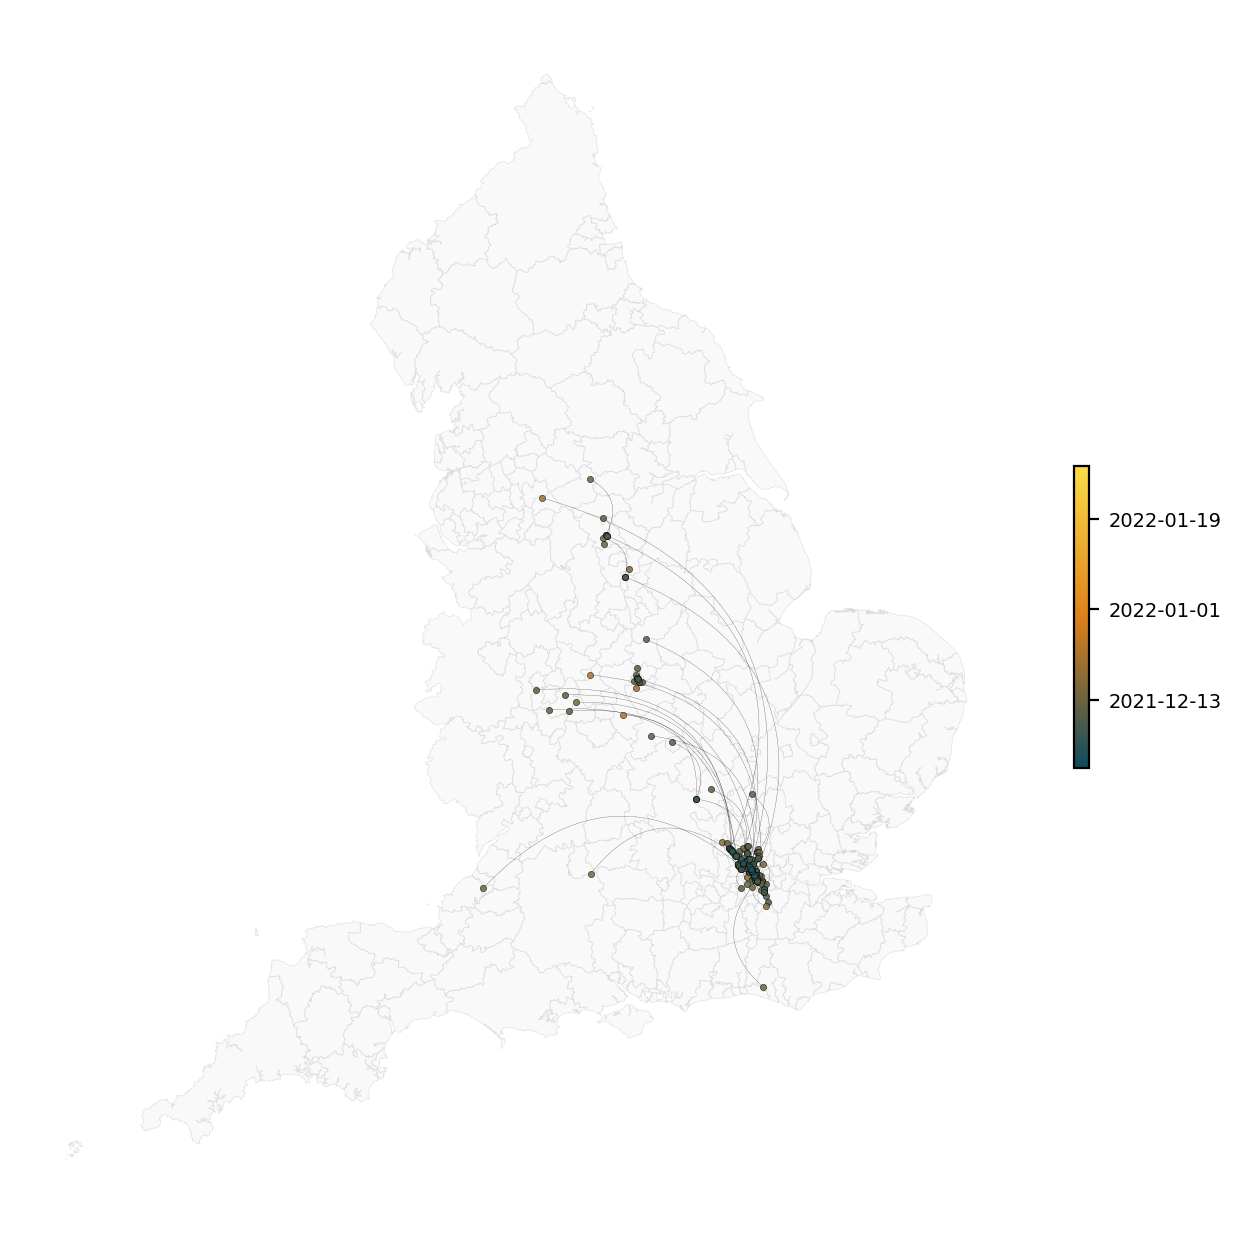

In [12]:
## specify date cut-off
cutoff_date = '2021-12-10'

## generate map
fig, ax = plt.subplots(1,1, figsize=(8, 8), dpi=200)
uk_map.plot(ax=ax, color='whitesmoke', ec='lightgrey', linewidth=0.25, alpha=0.6)
for index, row in tqdm.tqdm(mcc_edge_df[mcc_edge_df.head_date <= cutoff_date].iterrows()):
    head_pos = (row['head_long_3395'], row['head_lat_3395'])
    tail_pos = (row['tail_long_3395'], row['tail_lat_3395'])
    head_date = date_dec_map[row['head_date']]
    tail_date = date_dec_map[row['tail_date']]

    kw = dict(color="black", linewidth=0.1, alpha=0.75)

    liney = mpatches.FancyArrowPatch(head_pos, tail_pos, shrinkA=0, shrinkB=0,
                                     arrowstyle="-", connectionstyle="arc3, rad=.5", **kw)
    
    ax.add_patch(liney)

    ax.scatter(head_pos[0], head_pos[1], s=5, color=colour_dict[head_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=5)
    ax.scatter(tail_pos[0], tail_pos[1], s=5, color=colour_dict[tail_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=6)

bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.25)
new_ticks = []
for i in bar.get_ticks():
    new_ticks.append(get_date_str(i))
bar.set_ticks(bar.get_ticks())
bar.set_ticklabels(new_ticks)
bar.ax.tick_params(labelsize=7)

ax.set_axis_off()
        
plt.savefig("./figures/viral_movement_maps/vMov_%s_map.pdf" % cutoff_date, bbox_inches='tight', dpi=200)
    
plt.show()


2680it [01:24, 31.58it/s]


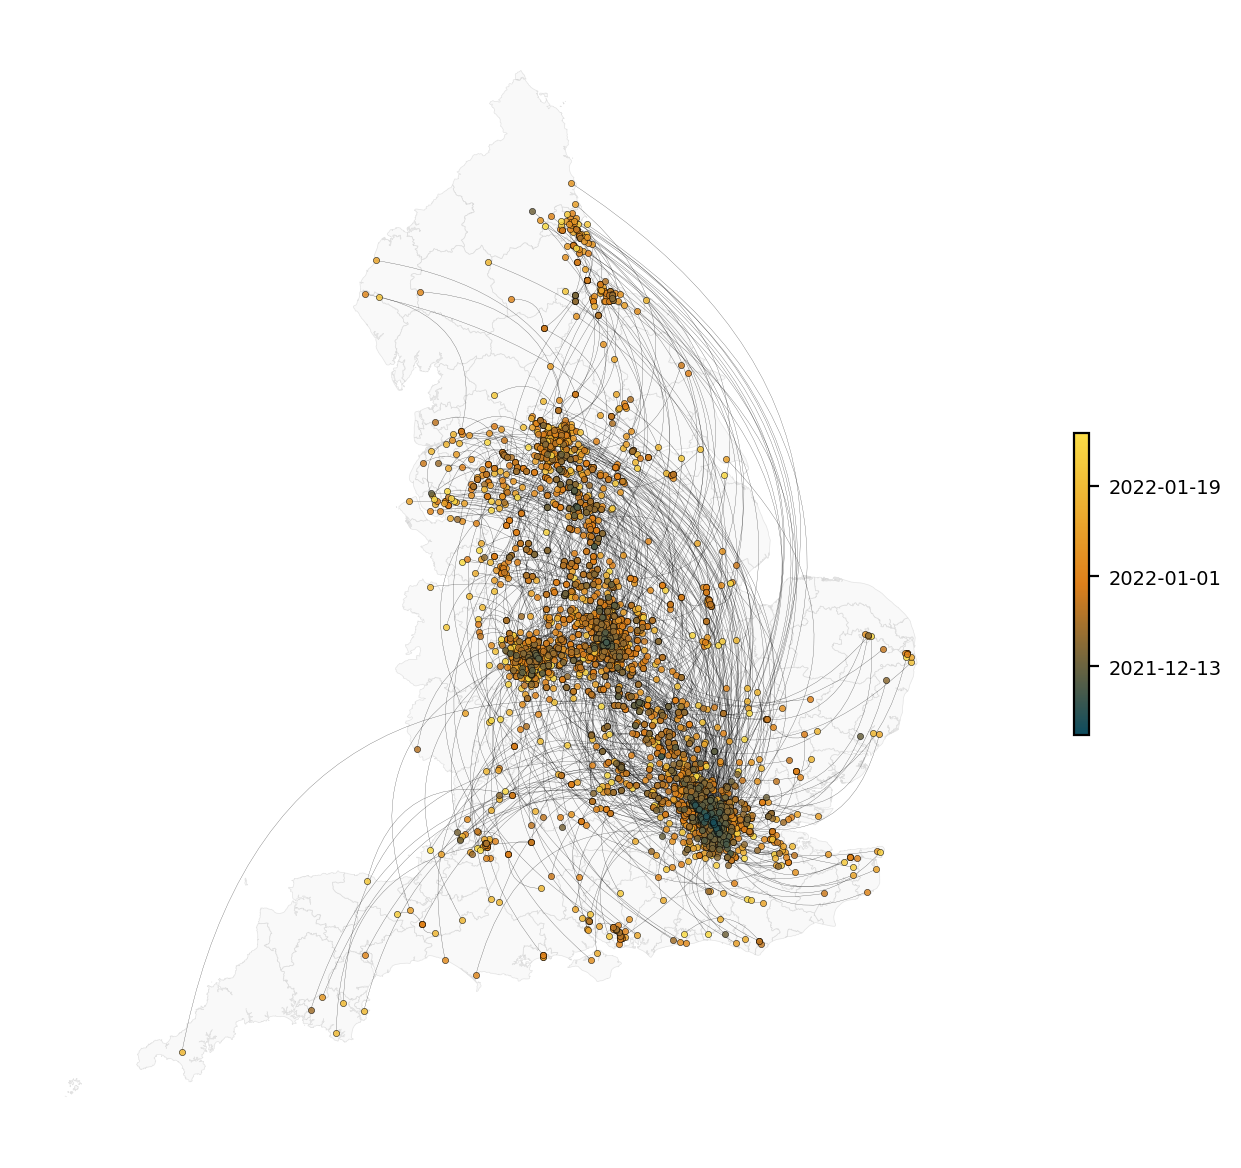

In [13]:
## specify date cut-off
cutoff_date = '2021-12-31'

## generate map
fig, ax = plt.subplots(1,1, figsize=(8, 8), dpi=200)
uk_map.plot(ax=ax, color='whitesmoke', ec='lightgrey', linewidth=0.25, alpha=0.6)
for index, row in tqdm.tqdm(mcc_edge_df[mcc_edge_df.head_date <= cutoff_date].iterrows()):
    head_pos = (row['head_long_3395'], row['head_lat_3395'])
    tail_pos = (row['tail_long_3395'], row['tail_lat_3395'])
    head_date = date_dec_map[row['head_date']]
    tail_date = date_dec_map[row['tail_date']]

    kw = dict(color="black", linewidth=0.1, alpha=0.75)

    liney = mpatches.FancyArrowPatch(head_pos, tail_pos, shrinkA=0, shrinkB=0,
                                     arrowstyle="-", connectionstyle="arc3, rad=.5", **kw)
    
    ax.add_patch(liney)

    ax.scatter(head_pos[0], head_pos[1], s=5, color=colour_dict[head_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=5)
    ax.scatter(tail_pos[0], tail_pos[1], s=5, color=colour_dict[tail_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=6)

bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.25)
new_ticks = []
for i in bar.get_ticks():
    new_ticks.append(get_date_str(i))
bar.set_ticks(bar.get_ticks())
bar.set_ticklabels(new_ticks)
bar.ax.tick_params(labelsize=7)

ax.set_axis_off()
        
# plt.savefig("./figures/viral_movement_maps/vMov_%s_map.pdf" % cutoff_date, bbox_inches='tight', dpi=200)
    
plt.show()


In [ ]:
## specify date cut-off
cutoff_date = '2022-01-15'

## generate map
fig, ax = plt.subplots(1,1, figsize=(8, 8), dpi=200)
uk_map.plot(ax=ax, color='whitesmoke', ec='lightgrey', linewidth=0.25, alpha=0.6)
for index, row in tqdm.tqdm(mcc_edge_df[mcc_edge_df.head_date <= cutoff_date].iterrows()):
    head_pos = (row['head_long_3395'], row['head_lat_3395'])
    tail_pos = (row['tail_long_3395'], row['tail_lat_3395'])
    head_date = date_dec_map[row['head_date']]
    tail_date = date_dec_map[row['tail_date']]

    kw = dict(color="black", linewidth=0.1, alpha=0.75)

    liney = mpatches.FancyArrowPatch(head_pos, tail_pos, shrinkA=0, shrinkB=0,
                                     arrowstyle="-", connectionstyle="arc3, rad=.5", **kw)
    
    ax.add_patch(liney)

    ax.scatter(head_pos[0], head_pos[1], s=5, color=colour_dict[head_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=5)
    ax.scatter(tail_pos[0], tail_pos[1], s=5, color=colour_dict[tail_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=6)

bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.25)
new_ticks = []
for i in bar.get_ticks():
    new_ticks.append(get_date_str(i))
bar.set_ticks(bar.get_ticks())
bar.set_ticklabels(new_ticks)
bar.ax.tick_params(labelsize=7)

ax.set_axis_off()
        
plt.savefig("./figures/viral_movement_maps/vMov_%s_map.pdf" % cutoff_date, bbox_inches='tight', dpi=200)
    
plt.show()


In [ ]:
## specify date cut-off
cutoff_date = '2022-01-31'

## generate map
fig, ax = plt.subplots(1,1, figsize=(8, 8), dpi=200)
uk_map.plot(ax=ax, color='whitesmoke', ec='lightgrey', linewidth=0.25, alpha=0.6)
for index, row in tqdm.tqdm(mcc_edge_df[mcc_edge_df.head_date <= cutoff_date].iterrows()):
    head_pos = (row['head_long_3395'], row['head_lat_3395'])
    tail_pos = (row['tail_long_3395'], row['tail_lat_3395'])
    head_date = date_dec_map[row['head_date']]
    tail_date = date_dec_map[row['tail_date']]

    kw = dict(color="black", linewidth=0.1, alpha=0.75)

    liney = mpatches.FancyArrowPatch(head_pos, tail_pos, shrinkA=0, shrinkB=0,
                                     arrowstyle="-", connectionstyle="arc3, rad=.5", **kw)
    
    ax.add_patch(liney)

    ax.scatter(head_pos[0], head_pos[1], s=5, color=colour_dict[head_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=5)
    ax.scatter(tail_pos[0], tail_pos[1], s=5, color=colour_dict[tail_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=6)

bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.25)
new_ticks = []
for i in bar.get_ticks():
    new_ticks.append(get_date_str(i))
bar.set_ticks(bar.get_ticks())
bar.set_ticklabels(new_ticks)
bar.ax.tick_params(labelsize=7)

ax.set_axis_off()
        
plt.savefig("./figures/viral_movement_maps/vMov_%s_map.pdf" % cutoff_date, bbox_inches='tight', dpi=200)
    
plt.show()
